# Loan Approval Prediction - Exploratory Data Analysis

### Step 1: Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

### Step 2: Import Loan  Dataset

In [2]:
df = pd.read_csv(r'prosperLoanDataCleaned.csv')
df.head()

,Term,MonthsOfEmployementExperience,IsHomeowner,OpenCreditLines,TotalInquiries,AvailableBankcardCredit,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,LoanNumber,LoanAmount,MonthlyInstallment,InterestRate,IsEmployed,AverageCreditScore,AnyDelinquencies,GoodLoan
0,36,2.000000,1,4.000000,3,1500.000000,0.17,1,3083.333333,19141,9425,330.43,0.1580,1,650,1,1
1,36,96.071582,0,9.260164,1,11210.225447,0.06,1,2083.333333,6466,3001,123.32,0.2750,1,490,1,1
2,36,19.000000,0,2.000000,5,2580.000000,0.27,1,1666.666667,20907,1000,33.81,0.1325,1,650,1,1
3,36,1.000000,0,7.000000,4,3626.000000,0.18,1,2416.666667,125045,4000,137.39,0.1435,1,690,0,0
4,36,121.000000,1,9.000000,1,178.000000,0.49,1,5500.000000,63982,4000,173.71,0.3177,1,710,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55106 entries, 0 to 55105
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Term                           55106 non-null  int64  
 1   MonthsOfEmployementExperience  55106 non-null  float64
 2   IsHomeowner                    55106 non-null  int64  
 3   OpenCreditLines                55106 non-null  float64
 4   TotalInquiries                 55106 non-null  int64  
 5   AvailableBankcardCredit        55106 non-null  float64
 6   DebtToIncomeRatio              55106 non-null  float64
 7   IncomeVerifiable               55106 non-null  int64  
 8   StatedMonthlyIncome            55106 non-null  float64
 9   LoanNumber                     55106 non-null  int64  
 10  LoanAmount                     55106 non-null  int64  
 11  MonthlyInstallment             55106 non-null  float64
 12  InterestRate                   55106 non-null 

### Step 3: Data Pre-processing

In [4]:
df = df.drop(['LoanNumber'], axis=1)
categorical = ['Term','IsHomeowner','IsEmployed','AnyDelinquencies','IncomeVerifiable']
numerical = ['LoanAmount','InterestRate','MonthlyInstallment','MonthsOfEmployementExperience','AverageCreditScore'
             ,'OpenCreditLines','TotalInquiries','AvailableBankcardCredit','DebtToIncomeRatio','StatedMonthlyIncome']

In [5]:
df[numerical].skew()

LoanAmount                        1.646822
InterestRate                      0.115913
MonthlyInstallment                1.953124
MonthsOfEmployementExperience     1.834853
AverageCreditScore               -1.351894
OpenCreditLines                   1.131160
TotalInquiries                    6.574083
AvailableBankcardCredit           7.593415
DebtToIncomeRatio                12.416432
StatedMonthlyIncome              44.534218
dtype: float64

In [6]:
skewed_features = ['TotalInquiries', 'AvailableBankcardCredit', 'DebtToIncomeRatio', 'StatedMonthlyIncome']

for feature in skewed_features:
    df[feature] = np.log1p(df[feature])
    

In [7]:
Q1 = df[numerical].quantile(0.25)
Q3 = df[numerical].quantile(0.75)
IQR = Q3 - Q1

# Calculate median
median = df[numerical].median()

# Identify outliers
outliers_lower = (df[numerical] < (Q1 - 1.5 * IQR))
outliers_upper = (df[numerical] > (Q3 + 1.5 * IQR))

# Replace outliers with median
df[numerical] = df[numerical].mask(outliers_lower, median, axis=1)
df[numerical] = df[numerical].mask(outliers_upper, median, axis=1)

In [8]:
df[numerical].skew()

LoanAmount                       1.106712
InterestRate                     0.115913
MonthlyInstallment               0.980513
MonthsOfEmployementExperience    0.856838
AverageCreditScore              -0.158725
OpenCreditLines                  0.453486
TotalInquiries                  -0.074052
AvailableBankcardCredit         -0.734401
DebtToIncomeRatio                0.325207
StatedMonthlyIncome             -0.044581
dtype: float64

### Step 4: Performing Exploratory Data Analysis

In [9]:
df.describe()

,Term,MonthsOfEmployementExperience,IsHomeowner,OpenCreditLines,TotalInquiries,AvailableBankcardCredit,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,LoanAmount,MonthlyInstallment,InterestRate,IsEmployed,AverageCreditScore,AnyDelinquencies,GoodLoan
count,55106.000000,55106.000000,55106.000000,55106.000000,55106.000000,55106.000000,55106.000000,55106.000000,55106.000000,55106.000000,55106.000000,55106.000000,55106.000000,55106.000000,55106.000000,55106.000000
mean,37.248213,66.350954,0.479240,8.093467,1.729962,8.199541,0.195711,0.918557,8.367557,5539.703027,199.946330,0.202293,0.976591,688.238885,0.256723,0.668530
std,7.800320,50.984545,0.499573,4.059213,0.824806,1.788072,0.092558,0.273517,0.543013,3769.279027,132.391362,0.081249,0.151201,67.822037,0.436829,0.470746
min,12.000000,0.000000,0.000000,0.000000,0.000000,2.302585,0.000000,0.000000,6.763692,1000.000000,0.000000,0.000000,0.000000,530.000000,0.000000,0.000000
25%,36.000000,24.000000,0.000000,5.000000,1.098612,7.180070,0.131028,1.000000,8.006701,3000.000000,102.520000,0.136500,1.000000,650.000000,0.000000,0.000000
50%,36.000000,63.000000,0.000000,8.000000,1.791759,8.382461,0.198851,1.000000,8.335112,4800.000000,173.710000,0.198200,1.000000,690.000000,0.000000,1.000000
75%,36.000000,96.071582,1.000000,10.000000,2.302585,9.324671,0.246860,1.000000,8.740497,7500.000000,273.227500,0.269900,1.000000,730.000000,1.000000,1.000000
max,60.000000,224.000000,1.000000,20.000000,4.094345,13.378997,0.457425,1.000000,9.924662,16250.000000,612.890000,0.360000,1.000000,850.000000,1.000000,1.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55106 entries, 0 to 55105
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Term                           55106 non-null  int64  
 1   MonthsOfEmployementExperience  55106 non-null  float64
 2   IsHomeowner                    55106 non-null  int64  
 3   OpenCreditLines                55106 non-null  float64
 4   TotalInquiries                 55106 non-null  float64
 5   AvailableBankcardCredit        55106 non-null  float64
 6   DebtToIncomeRatio              55106 non-null  float64
 7   IncomeVerifiable               55106 non-null  int64  
 8   StatedMonthlyIncome            55106 non-null  float64
 9   LoanAmount                     55106 non-null  int64  
 10  MonthlyInstallment             55106 non-null  float64
 11  InterestRate                   55106 non-null  float64
 12  IsEmployed                     55106 non-null 

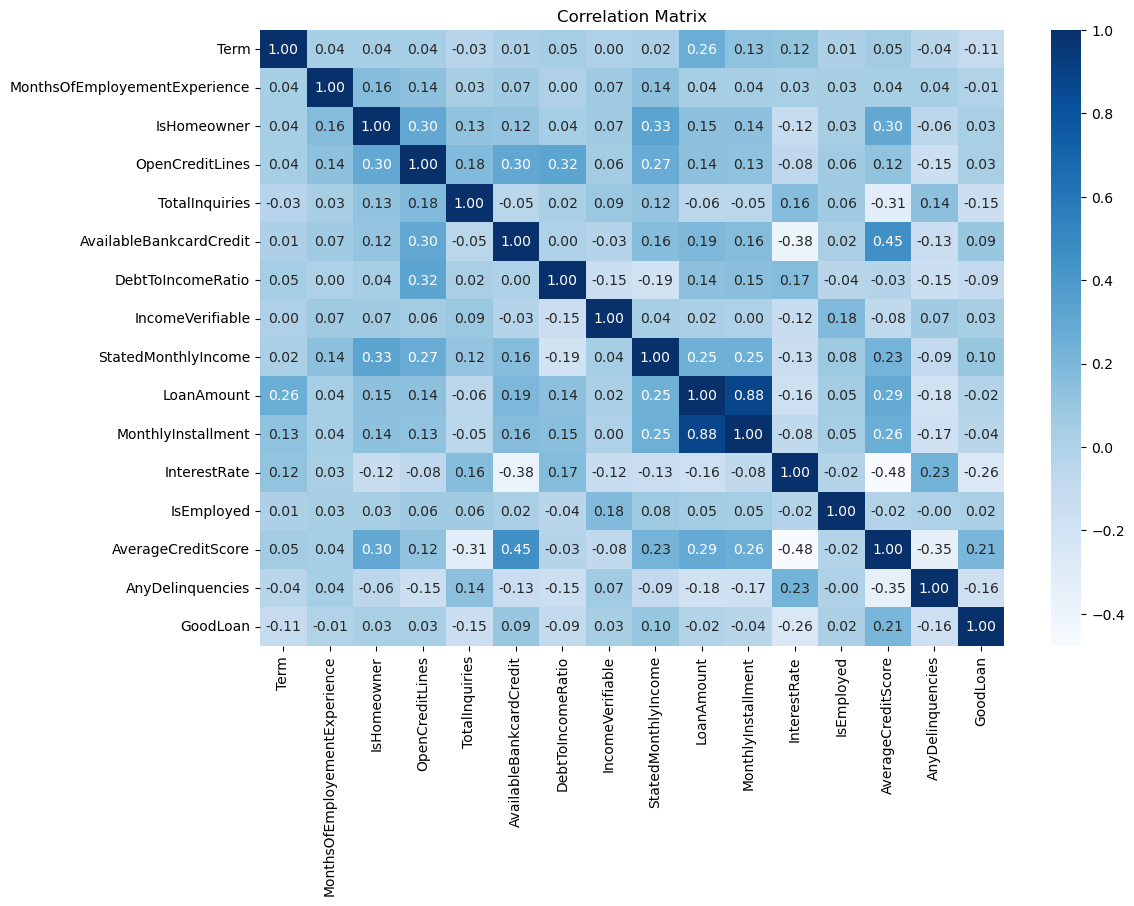

In [11]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

    The target variable is GoodLoan, which is a binary classification of whether a loan is good or not. Based on the correlation matrix in the image, here are some of the variables that are related to GoodLoan:

- Interest rate: This has a negative correlation of 0.26 with GoodLoan. Low-interest rates are associated with an increased likelihood of a good loan.

- AverageCreditScore: This has a positive correlation of 0.21 with GoodLoan. This means a higher credit score is associated with an increased likelihood of a good loan.

- AnyDelinquencies: This has a weak negative correlation of 0.16 with GoodLoan. Fewer delinquencies are associated with an increased likelihood of a good loan.

- TotalInquiries: This has a weak negative correlation of 0.15 with GoodLoan.Fewer credit inquiries are weakly associated with a higher likelihood of a good loan. 

- Term: This has a weak negative correlation of 0.11 with GoodLoan. This means a lower, shorter term is associated with an increased likelihood of a good loan.

- StatedMonthlyIncome: This has a weak positive correlation of 0.10 with GoodLoan. This means that a higher stated monthly income is associated with an increased likelihood of a good loan.

- DebtToIncomeRatio: This has a weak negative correlation of 0.09 with GoodLoan. This means a lower debt-to-income ratio is associated with an increased likelihood of a good loan.


- AvailableBankcardCredit: This has a weak positive correlation of 0.09 with GoodLoan. This means a higher available bankcard credit limit is associated with an increased likelihood of a good loan.

    Other variables related to GoodLoan include LoanAmount, InterestRate, MonthlyInstallment, IsEmployed, MonthsOfEmployementExperience, and IsHomeowner. However, the strength of their correlations is lower than those mentioned above.

In [12]:
df = df.sample(frac=1, random_state=42)
df

,Term,MonthsOfEmployementExperience,IsHomeowner,OpenCreditLines,TotalInquiries,AvailableBankcardCredit,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,LoanAmount,MonthlyInstallment,InterestRate,IsEmployed,AverageCreditScore,AnyDelinquencies,GoodLoan
2098,36,60.000000,1,8.000000,1.791759,5.894403,0.392042,1,9.127891,2000,0.00,0.2998,1,670,0,1
43905,36,9.000000,0,5.000000,2.302585,8.382404,0.412110,1,8.335112,1000,45.24,0.3500,1,630,0,0
46310,36,96.071582,0,9.260164,0.693147,9.324671,0.157004,1,6.803135,4500,188.58,0.2900,1,690,1,0
53388,36,63.000000,1,6.000000,1.791759,7.556951,0.322083,1,8.073819,4000,163.56,0.2712,1,610,0,0
32128,36,11.000000,1,9.000000,2.197225,4.934474,0.243688,0,8.335112,3000,108.13,0.1778,1,550,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44732,36,49.000000,1,4.000000,1.791759,8.860357,0.243688,0,8.335112,10000,348.91,0.1546,1,770,0,0
54343,36,22.000000,0,2.000000,1.945910,8.382404,0.243688,0,7.157995,1500,60.44,0.2600,1,670,1,1
38158,36,87.000000,0,6.000000,2.639057,6.198479,0.182322,1,8.383376,4000,159.46,0.2520,1,610,1,0
860,36,18.000000,1,8.000000,2.708050,8.889170,0.165514,1,8.141675,6000,203.61,0.1350,1,750,1,1


In [13]:
train,test = train_test_split(df, test_size=0.2, random_state=42)
train,val = train_test_split(train, test_size=0.25, random_state=42)

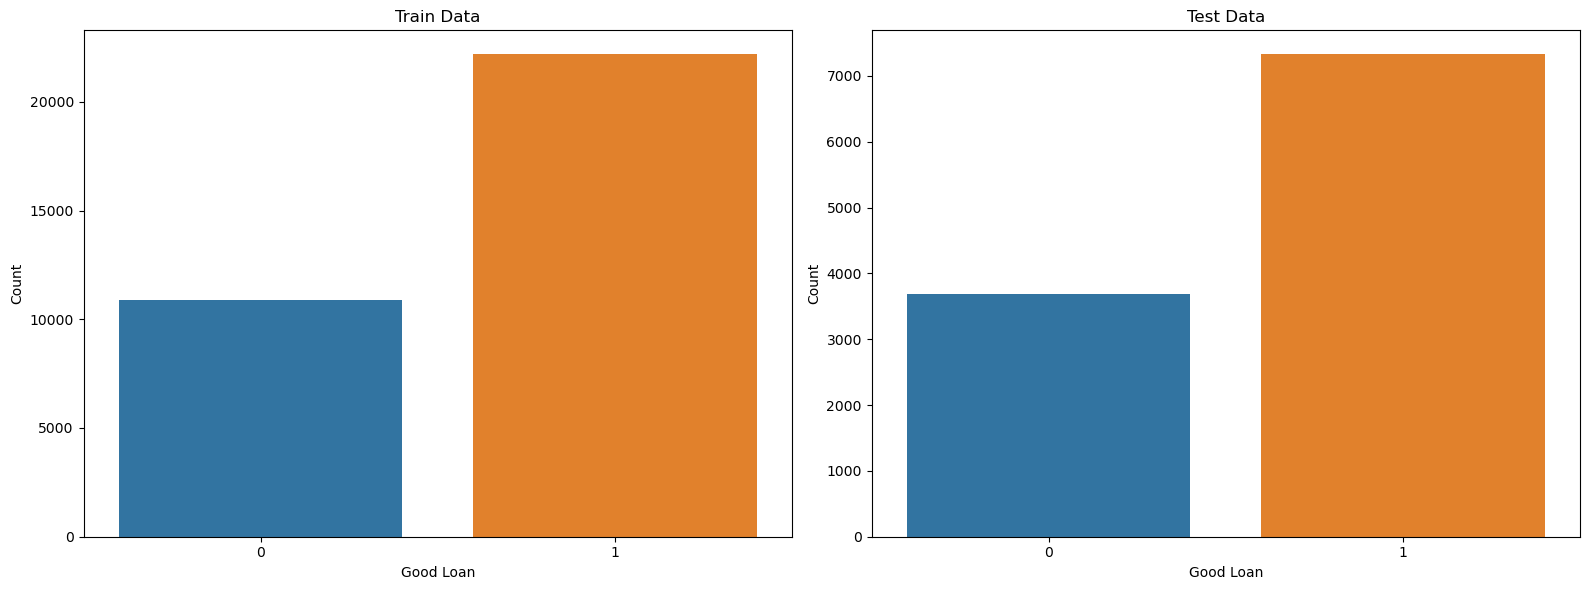

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot the first count plot on the left subplot
sns.countplot(x='GoodLoan', data=train, ax=axes[0])
axes[0].set_title('Train Data')
axes[0].set_xlabel('Good Loan')
axes[0].set_ylabel('Count')

# Plot the second count plot on the right subplot
sns.countplot(x='GoodLoan', data=test, ax=axes[1])
axes[1].set_title('Test Data')
axes[1].set_xlabel('Good Loan')
axes[1].set_ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

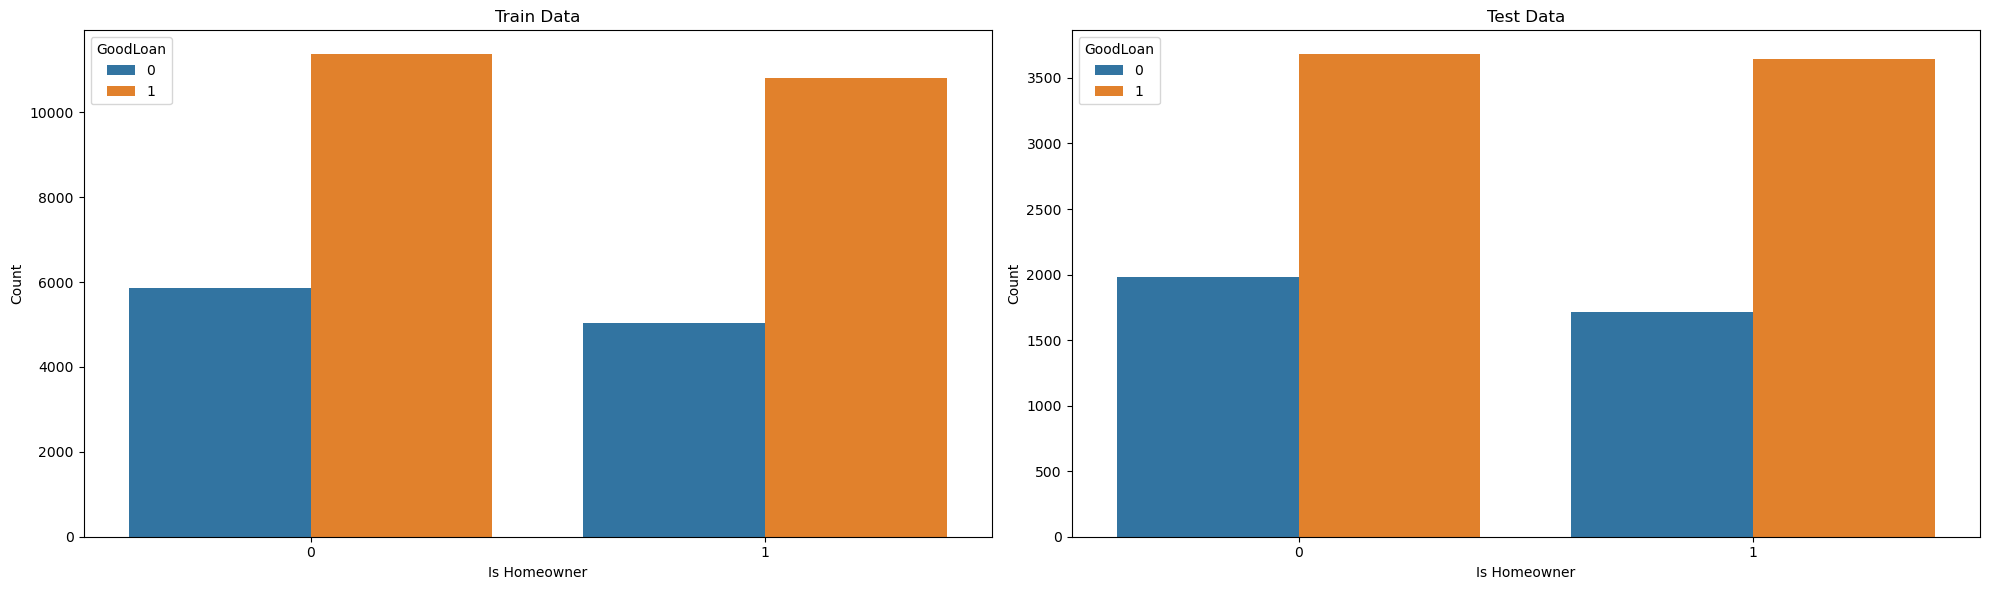

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))  # 1 row, 2 columns

# Plot on the first subplot
sns.countplot(x='IsHomeowner', hue='GoodLoan', data=train, ax=axes[0])
axes[0].set_title('Train Data')
axes[0].set_xlabel('Is Homeowner')
axes[0].set_ylabel('Count')

# Plot on the second subplot
sns.countplot(x='IsHomeowner', hue='GoodLoan', data=test, ax=axes[1])
axes[1].set_title('Test Data')
axes[1].set_xlabel('Is Homeowner')
axes[1].set_ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

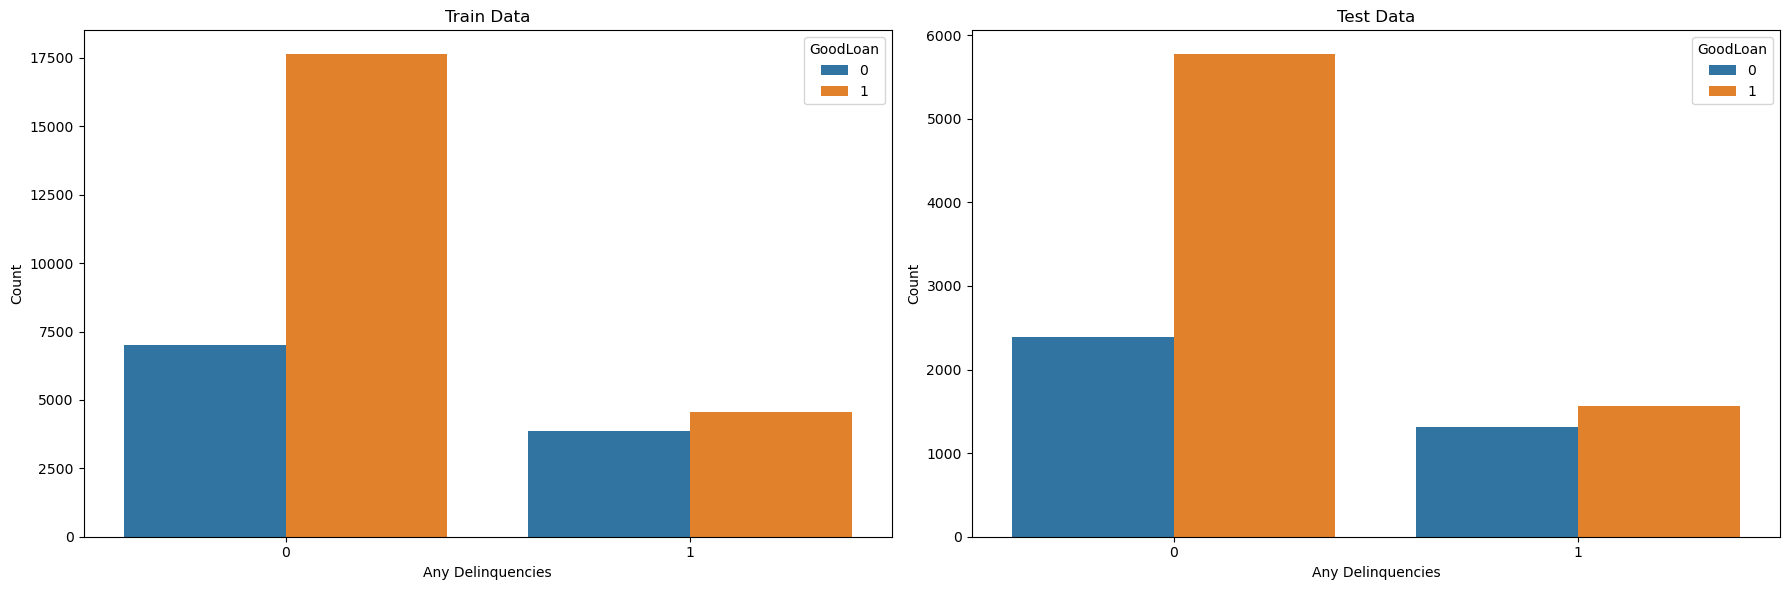

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the first count plot on the first subplot
sns.countplot(x='AnyDelinquencies', hue='GoodLoan', data=train, ax=axes[0])
axes[0].set_title('Train Data')
axes[0].set_xlabel('Any Delinquencies')
axes[0].set_ylabel('Count')

# Plot the second count plot on the second subplot
sns.countplot(x='AnyDelinquencies', hue='GoodLoan', data=test, ax=axes[1])
axes[1].set_title('Test Data')
axes[1].set_xlabel('Any Delinquencies')
axes[1].set_ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

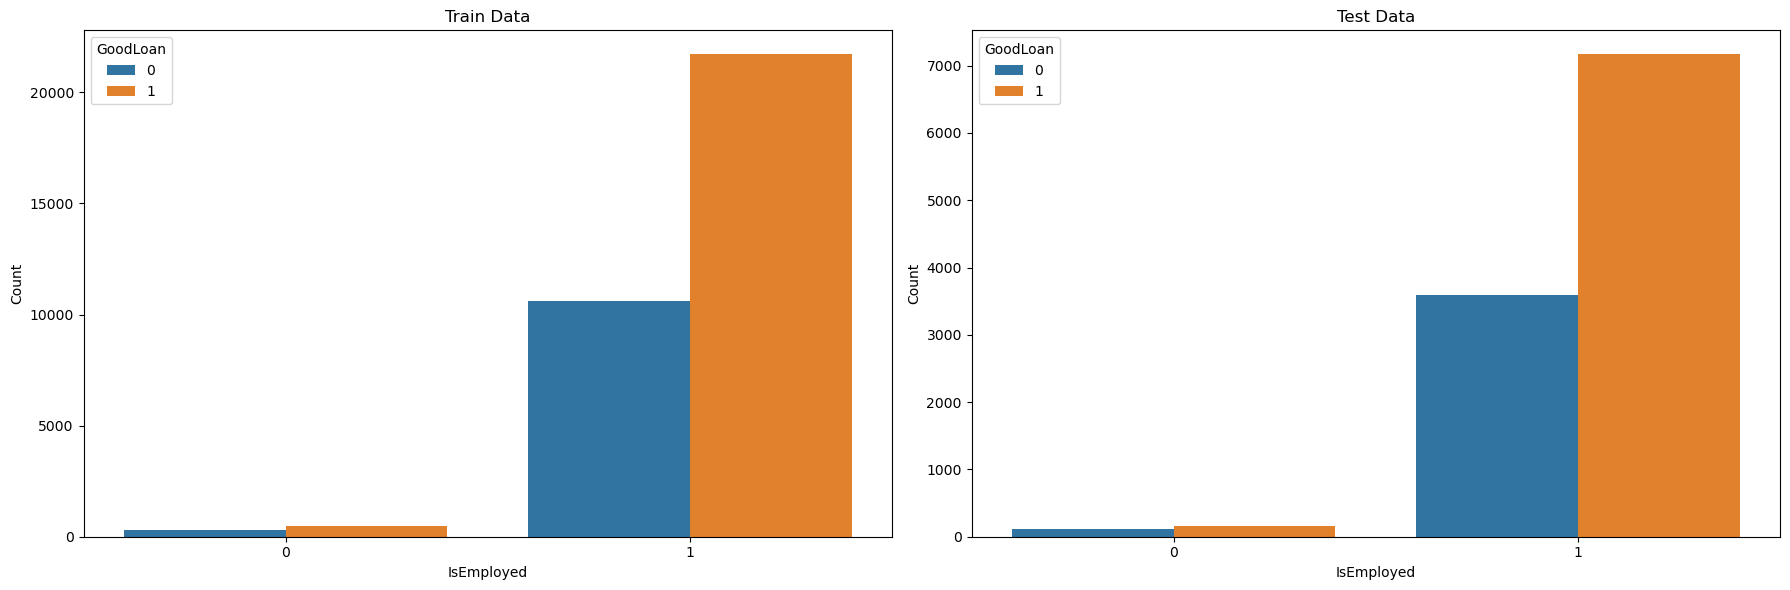

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the first count plot on the first subplot
sns.countplot(x='IsEmployed', hue='GoodLoan', data=train, ax=axes[0])
axes[0].set_title('Train Data')
axes[0].set_xlabel('IsEmployed')
axes[0].set_ylabel('Count')

# Plot the second count plot on the second subplot
sns.countplot(x='IsEmployed', hue='GoodLoan', data=test, ax=axes[1])
axes[1].set_title('Test Data')
axes[1].set_xlabel('IsEmployed')
axes[1].set_ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

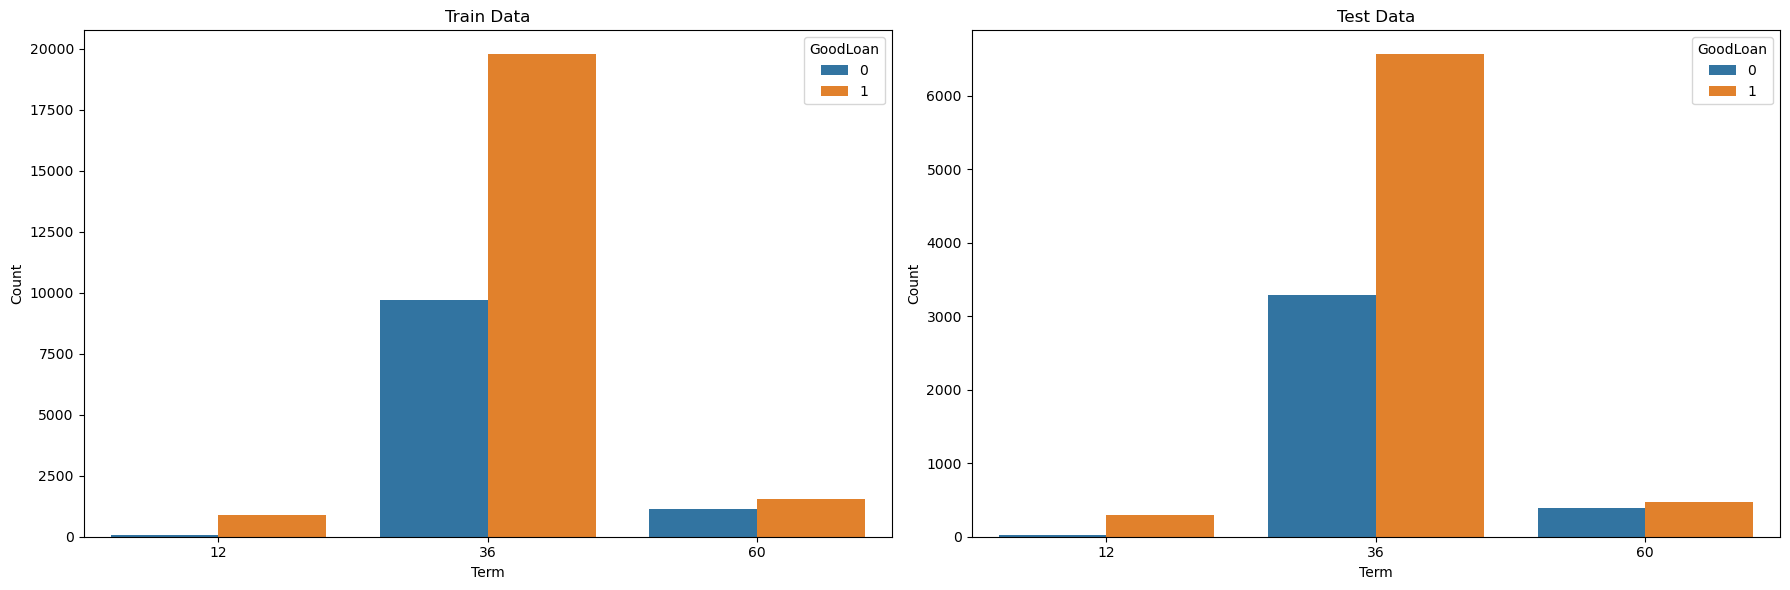

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the first count plot on the first subplot
sns.countplot(x='Term', hue='GoodLoan', data=train, ax=axes[0])
axes[0].set_title('Train Data')
axes[0].set_xlabel('Term')
axes[0].set_ylabel('Count')

# Plot the second count plot on the second subplot
sns.countplot(x='Term', hue='GoodLoan', data=test, ax=axes[1])
axes[1].set_title('Test Data')
axes[1].set_xlabel('Term')
axes[1].set_ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

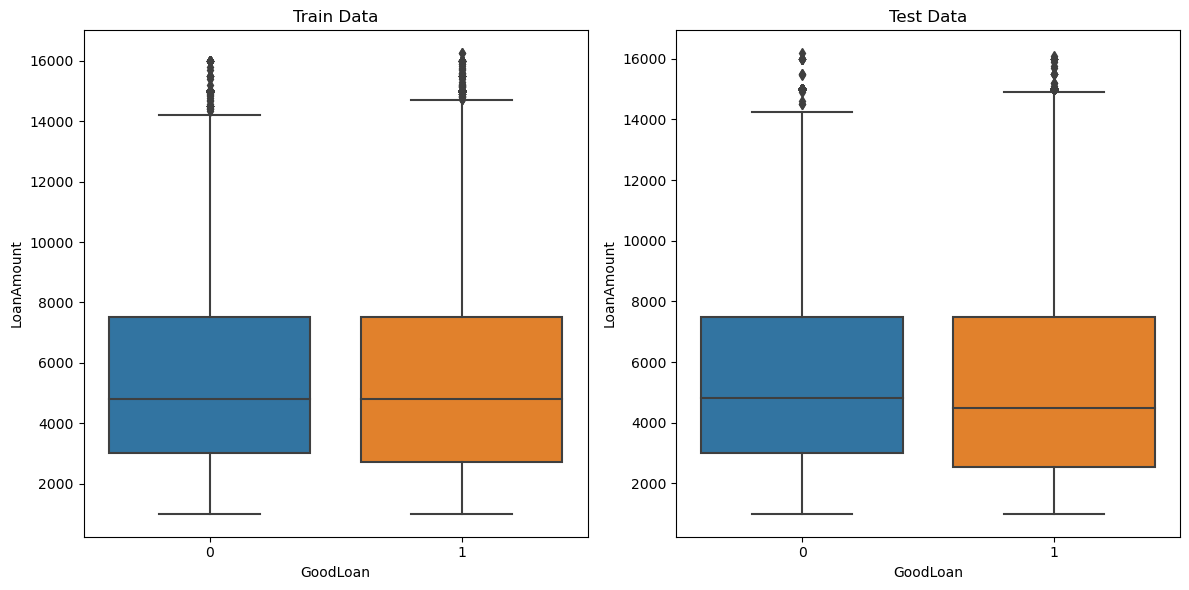

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the first seaborn boxplot on the first subplot
sns.boxplot(x='GoodLoan', y='LoanAmount', data=train, ax=axes[0])
axes[0].set_title('Train Data')

# Plot the second seaborn boxplot on the second subplot
sns.boxplot(x='GoodLoan', y='LoanAmount', data=test, ax=axes[1])
axes[1].set_title('Test Data')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

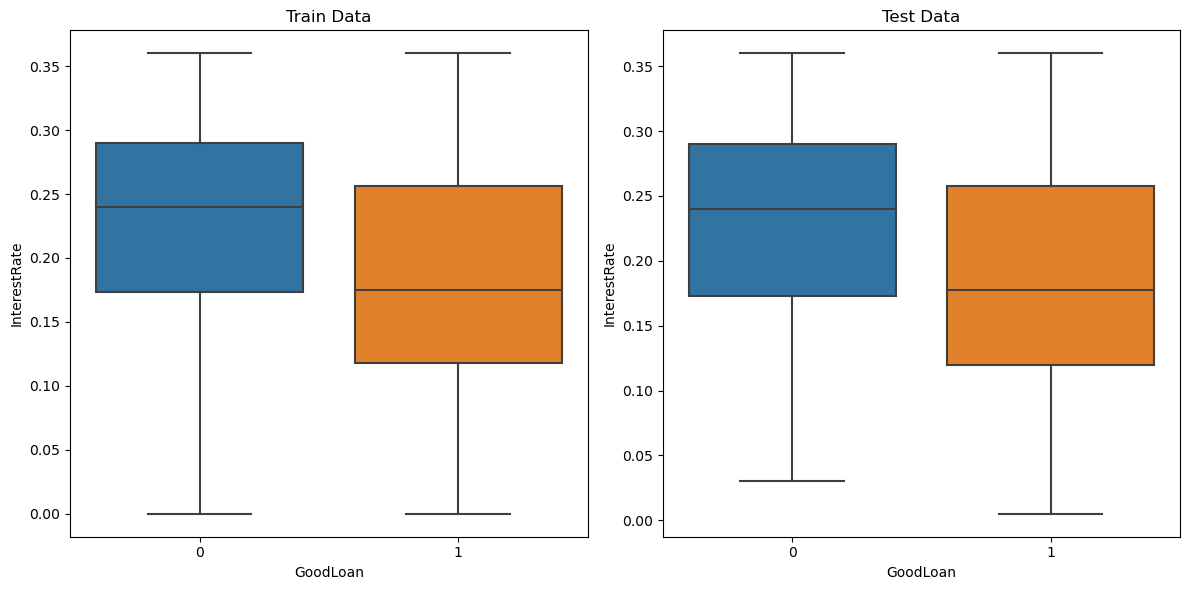

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the first seaborn boxplot on the first subplot
sns.boxplot(x='GoodLoan', y='InterestRate', data=train, ax=axes[0])
axes[0].set_title('Train Data')

# Plot the second seaborn boxplot on the second subplot
sns.boxplot(x='GoodLoan', y='InterestRate', data=test, ax=axes[1])
axes[1].set_title('Test Data')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

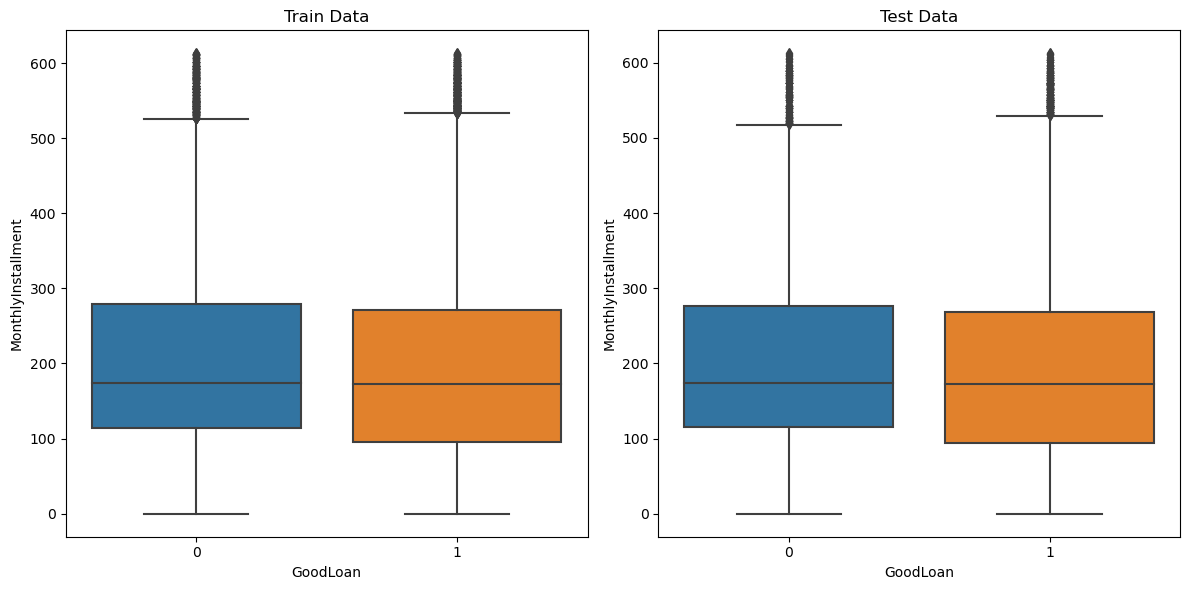

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the first seaborn boxplot on the first subplot
sns.boxplot(x='GoodLoan', y='MonthlyInstallment', data=train, ax=axes[0])
axes[0].set_title('Train Data')

# Plot the second seaborn boxplot on the second subplot
sns.boxplot(x='GoodLoan', y='MonthlyInstallment', data=test, ax=axes[1])
axes[1].set_title('Test Data')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

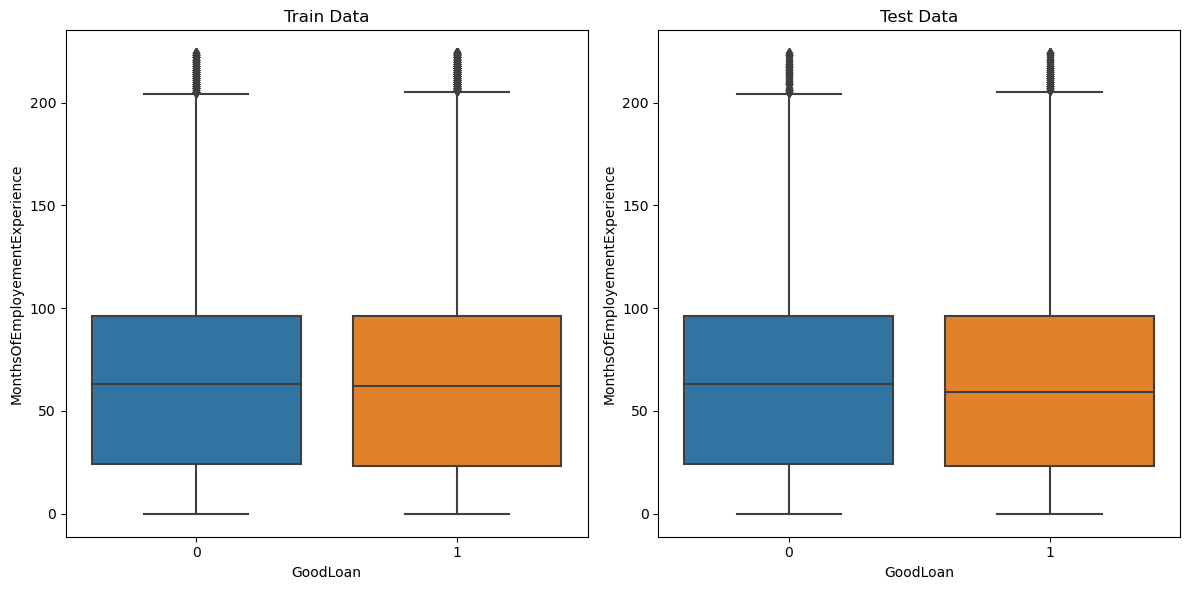

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the first seaborn boxplot on the first subplot
sns.boxplot(x='GoodLoan', y='MonthsOfEmployementExperience', data=train, ax=axes[0])
axes[0].set_title('Train Data')

# Plot the second seaborn boxplot on the second subplot
sns.boxplot(x='GoodLoan', y='MonthsOfEmployementExperience', data=test, ax=axes[1])
axes[1].set_title('Test Data')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

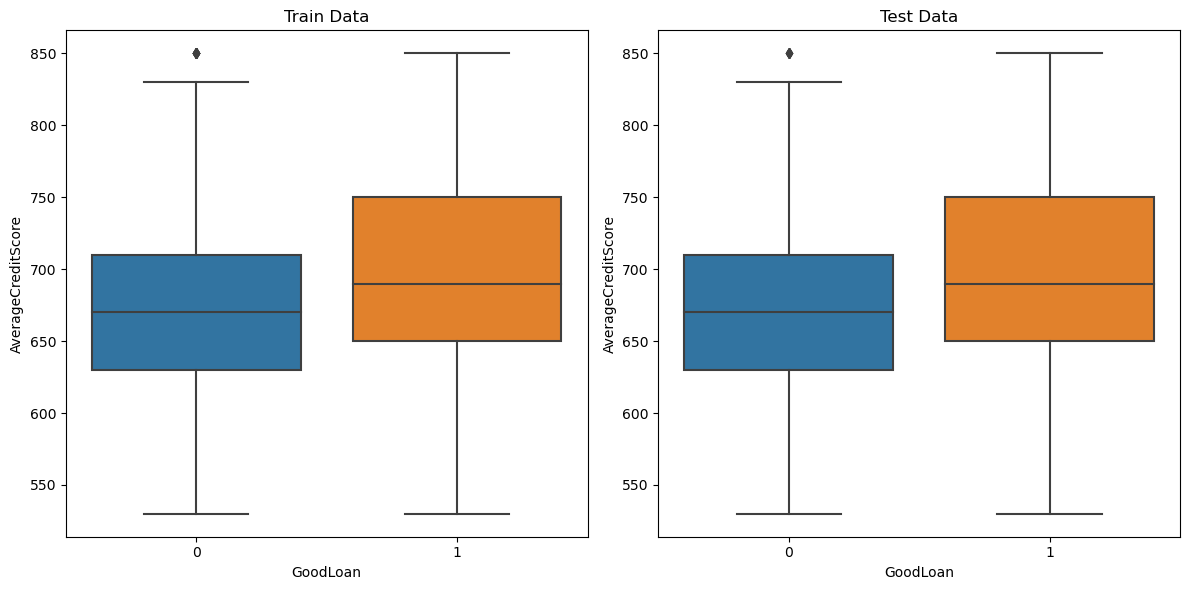

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the first seaborn boxplot on the first subplot
sns.boxplot(x='GoodLoan', y='AverageCreditScore', data=train, ax=axes[0])
axes[0].set_title('Train Data')

# Plot the second seaborn boxplot on the second subplot
sns.boxplot(x='GoodLoan', y='AverageCreditScore', data=test, ax=axes[1])
axes[1].set_title('Test Data')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

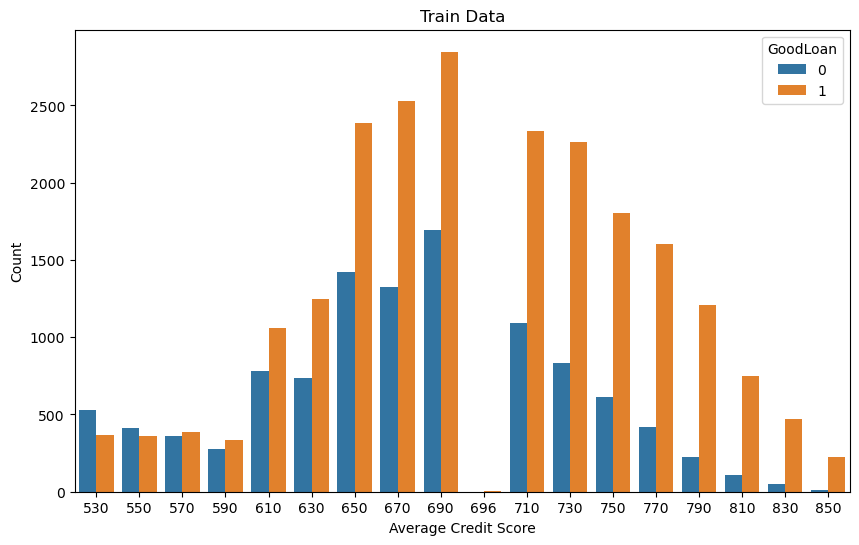

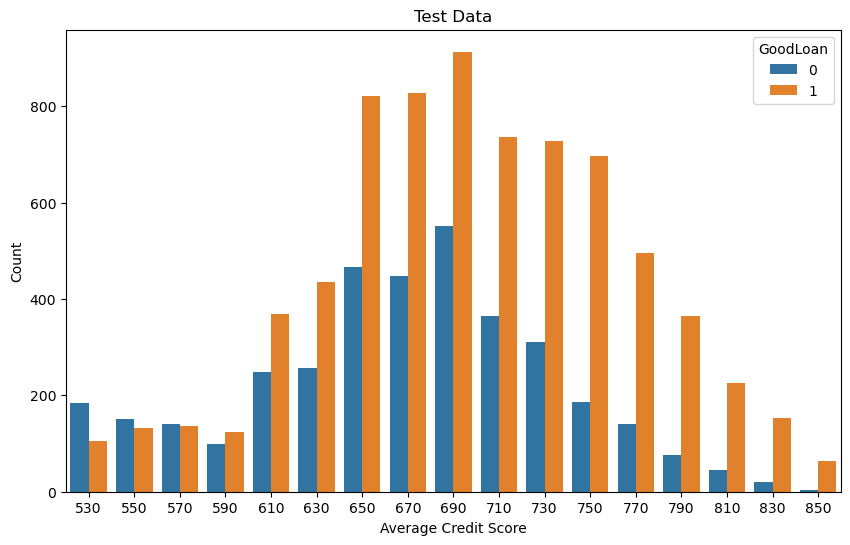

In [24]:
plt.figure(figsize=(10, 6))
sns.countplot(x='AverageCreditScore', hue='GoodLoan', data=train)
plt.title('Train Data')
plt.xlabel('Average Credit Score')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='AverageCreditScore', hue='GoodLoan', data=test)
plt.title('Test Data')
plt.xlabel('Average Credit Score')
plt.ylabel('Count')
plt.show()

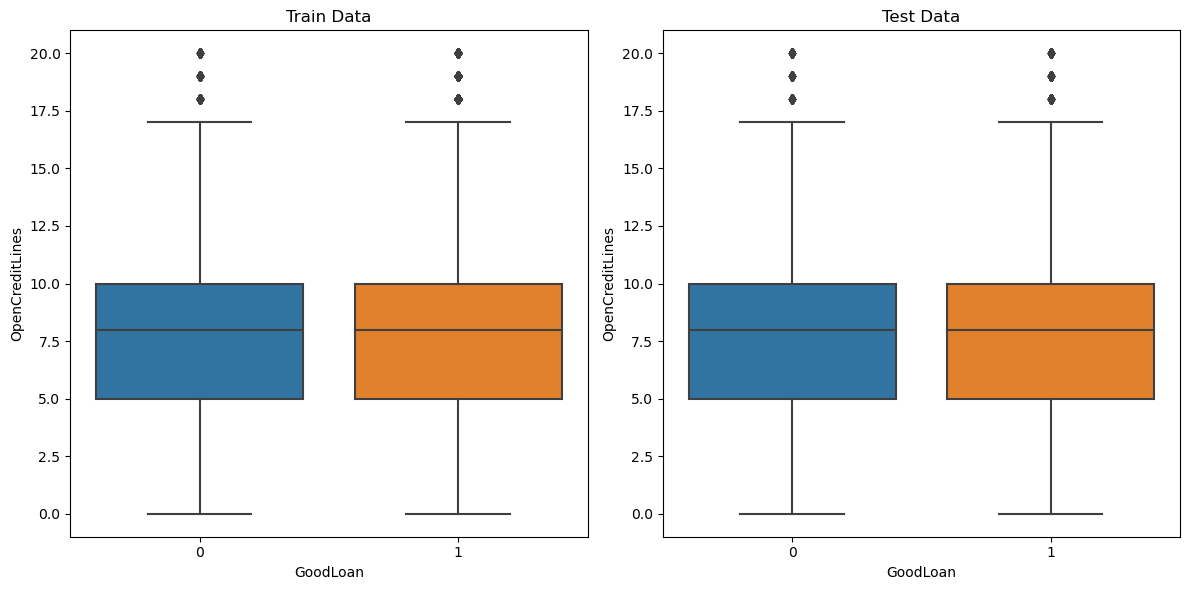

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the first seaborn boxplot on the first subplot
sns.boxplot(x='GoodLoan', y='OpenCreditLines', data=train, ax=axes[0])
axes[0].set_title('Train Data')

# Plot the second seaborn boxplot on the second subplot
sns.boxplot(x='GoodLoan', y='OpenCreditLines', data=test, ax=axes[1])
axes[1].set_title('Test Data')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

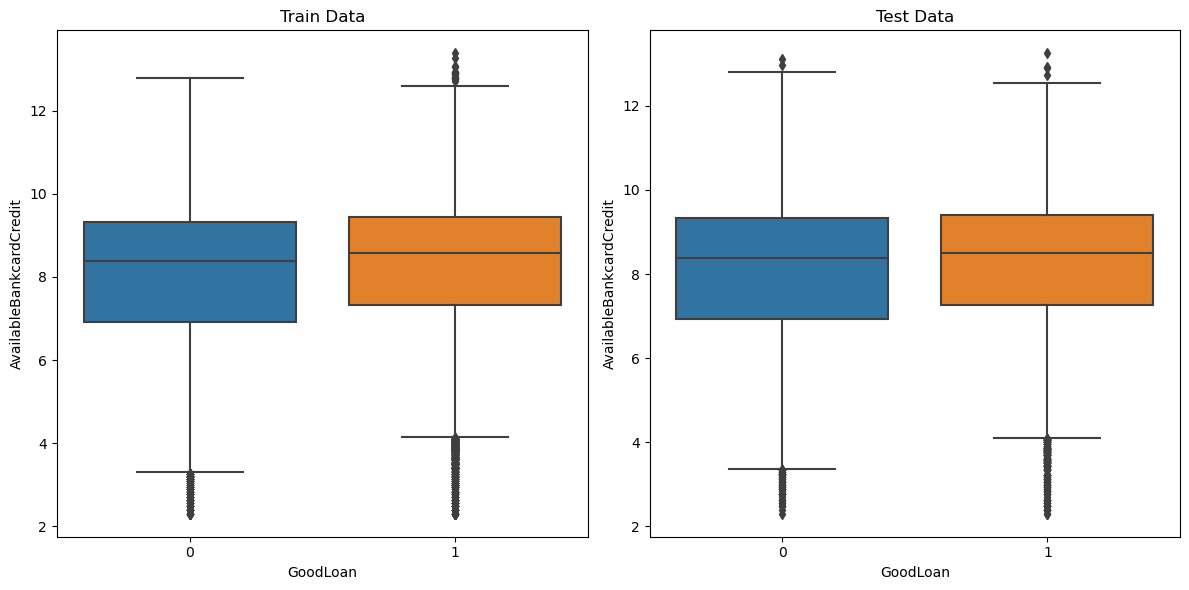

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the first seaborn boxplot on the first subplot
sns.boxplot(x='GoodLoan', y='AvailableBankcardCredit', data=train, ax=axes[0])
axes[0].set_title('Train Data')

# Plot the second seaborn boxplot on the second subplot
sns.boxplot(x='GoodLoan', y='AvailableBankcardCredit', data=test, ax=axes[1])
axes[1].set_title('Test Data')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

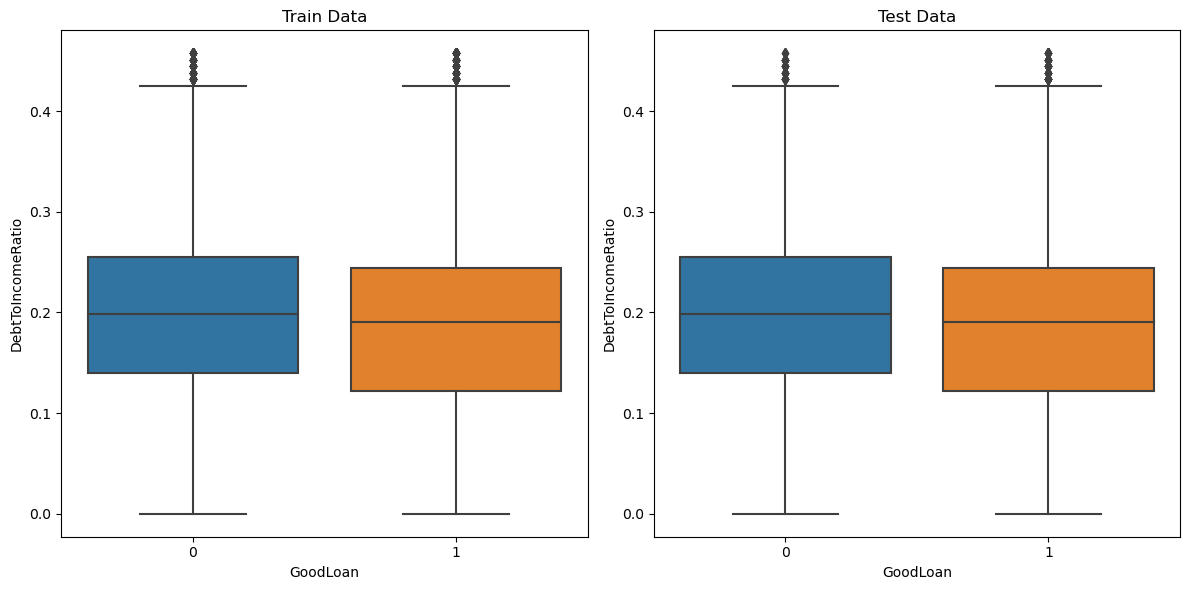

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the first seaborn boxplot on the first subplot
sns.boxplot(x='GoodLoan', y='DebtToIncomeRatio', data=train, ax=axes[0])
axes[0].set_title('Train Data')

# Plot the second seaborn boxplot on the second subplot
sns.boxplot(x='GoodLoan', y='DebtToIncomeRatio', data=test, ax=axes[1])
axes[1].set_title('Test Data')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

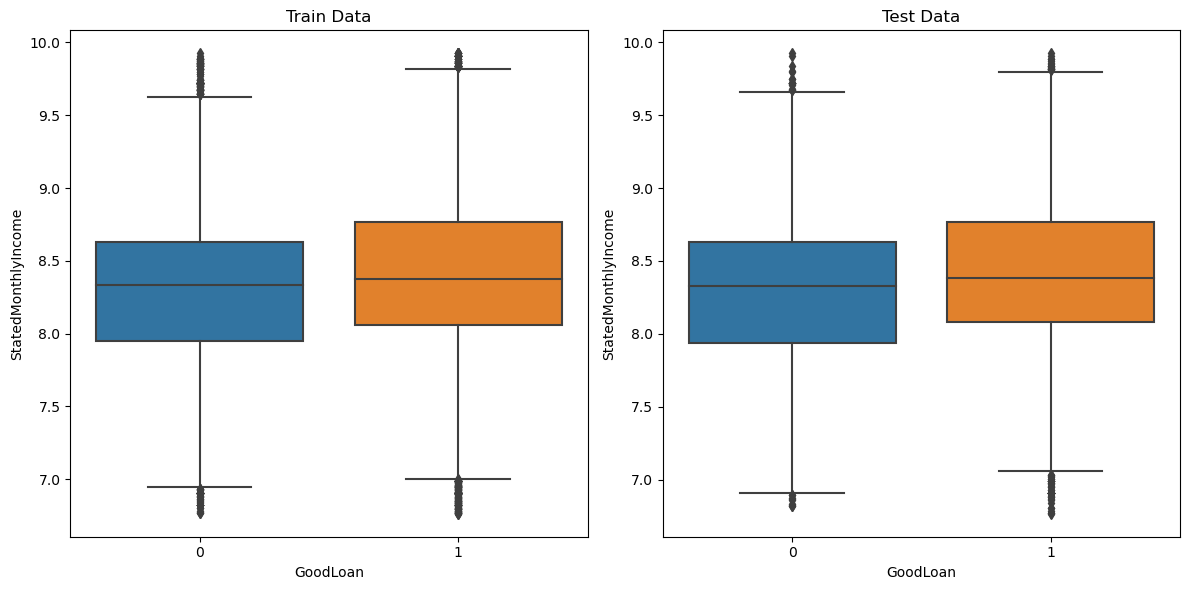

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the first seaborn boxplot on the first subplot
sns.boxplot(x='GoodLoan', y='StatedMonthlyIncome', data=train, ax=axes[0])
axes[0].set_title('Train Data')

# Plot the second seaborn boxplot on the second subplot
sns.boxplot(x='GoodLoan', y='StatedMonthlyIncome', data=test, ax=axes[1])
axes[1].set_title('Test Data')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

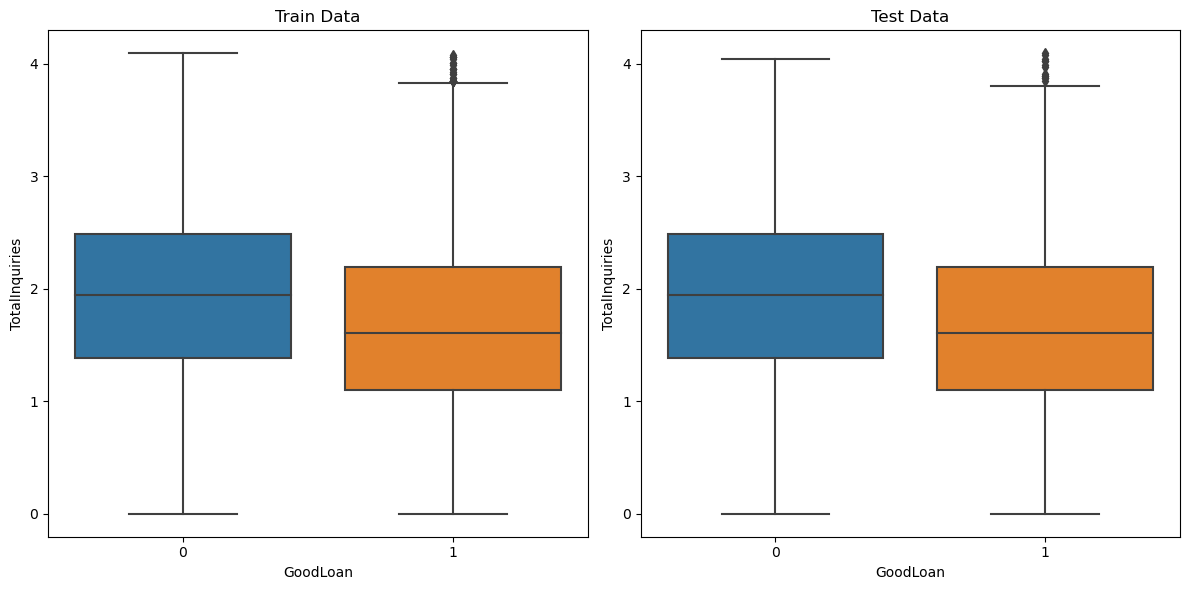

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the first seaborn boxplot on the first subplot
sns.boxplot(x='GoodLoan', y='TotalInquiries', data=train, ax=axes[0])
axes[0].set_title('Train Data')

# Plot the second seaborn boxplot on the second subplot
sns.boxplot(x='GoodLoan', y='TotalInquiries', data=test, ax=axes[1])
axes[1].set_title('Test Data')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()